# Computing the Error Distribution of R2

In [19]:
import os, sys
sys.path.insert(0, os.path.abspath('../.'))
import os.path as op
import numpy as np
import torch
from tqdm import tqdm

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots 
plt.style.use("science")
from IPython.display import set_matplotlib_formats
%config InlineBackend.figure_formats = ['svg']

import utils
from models.pc_two import DynPredNet

import models.data_loader as data_loader

In [20]:
plt.rcParams.update({'font.size': 16})

## Plot the error distribution

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# load two level
fpath = "../experiments/two_mnist_long/"
data_dir = "../data/three"
params = utils.Params(op.join(fpath, "params.json"))
model = DynPredNet(params, device).to(device)
# load weights
ckpt = utils.load_checkpoint(op.join(fpath, 'last.pth.tar'), model)
model.eval()


params.shuffle = False
params.cuda = True

In [22]:
dataloaders = data_loader.fetch_dataloader(['train'], data_dir, params)
dl = dataloaders['train']

In [23]:
R2_loss = None
for data_batch in tqdm(dl, total=len(dl)):
    data_batch = data_batch.to(device)
    sloss, tloss, r2_loss, r_first, r2 = model(data_batch)
    R2_loss = r2_loss if R2_loss is None else torch.cat((R2_loss, r2_loss), dim=0)

100%|██████████| 17/17 [01:50<00:00,  6.52s/it]


In [24]:
R2_loss.shape

torch.Size([8704, 19])

In [25]:
R2_loss

tensor([[0.3453, 0.6561, 0.4589,  ..., 0.3323, 0.4527, 0.3557],
        [1.4035, 0.3433, 0.1450,  ..., 0.8024, 0.0659, 0.2508],
        [0.2357, 0.7218, 1.3968,  ..., 0.1183, 0.0963, 0.1081],
        ...,
        [1.8291, 0.3168, 0.4163,  ..., 0.3385, 0.7920, 0.0501],
        [1.3207, 0.5875, 1.3671,  ..., 0.4658, 0.5412, 1.0791],
        [0.4762, 2.4280, 0.8729,  ..., 0.3885, 0.6026, 0.7942]],
       device='cuda:0', grad_fn=<CatBackward0>)

In [26]:
from scipy import stats

In [27]:
class KDEDist(stats.rv_continuous):
    
    def __init__(self, kde, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._kde = kde
    
    def _pdf(self, x):
        return self._kde.pdf(x)

In [28]:
data = R2_loss[:,1:].cpu().detach().numpy().flatten() 

In [29]:
kde = stats.gaussian_kde(data)

In [30]:
X = KDEDist(kde)

In [31]:
X.cdf(0.73)

0.7513670487463058

In [32]:
x = np.linspace(-1.5, 6, 100)

In [33]:
pdfs = np.zeros_like(x)
cdfs = np.zeros_like(x)

In [34]:
for idx, i in tqdm(enumerate(x), total=len(x)):
    pdfs[idx] = X.pdf(i)
    cdfs[idx] = X.cdf(i)

100%|██████████| 100/100 [04:07<00:00,  2.48s/it]


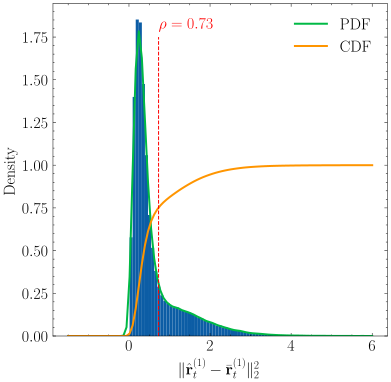

In [39]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.hist(data, bins=np.linspace(-1.5, 6, 100), density=True)
ax.plot(x, pdfs, linewidth=2, label="PDF")
ax.plot(x, cdfs, linewidth=2, label="CDF")

ax.vlines(0.73, 0, 1.75, color='red', linestyle='--')
ax.text(0.73, 1.8, r"$\rho = 0.73$", color='red', ha='left')
plt.xlabel(r"$\Vert\hat{\mathbf{r}}^{(1)}_t - \bar{\mathbf{r}}^{(1)}_t\Vert_2^2$")
plt.ylabel("Density")
plt.legend()

In [41]:
fig.savefig("figures/err_dist.pdf", bbox_inches='tight', pad_inches=0)

## Examples of bouncing detection

In [5]:
dataloaders = data_loader.fetch_dataloader(['test'], data_dir, params)
dl = dataloaders['test']
X = dl.dataset.data[:params.batch_size].to(device)

In [6]:
sloss, tloss, r2_loss, r_first, r2 = model(X)

In [7]:
r2_loss.shape

torch.Size([512, 19])

In [8]:
X = X.cpu().detach().numpy()
r2_loss = r2_loss.cpu().detach().numpy()

In [14]:
lst = [1, 4, 7, 10 , 13, 16]

/tmp/ipykernel_68999/2223245943.py:14: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


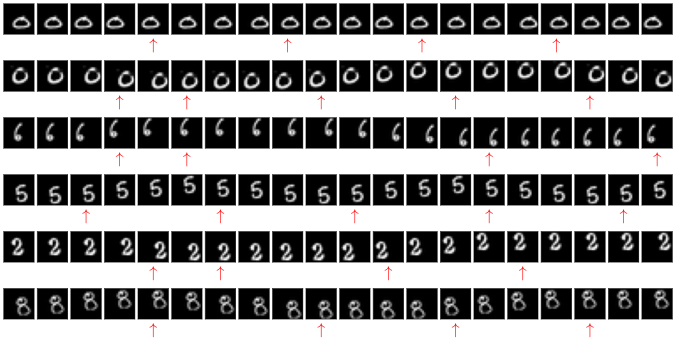

In [17]:
fig = plt.figure(figsize=[12, 6])
T = X.shape[1]
N = 18
M = 6
grid = plt.GridSpec(M, T, wspace=0.1, hspace=0.2)
for b in range(M):
    for t in range(T):
        ax = fig.add_subplot(grid[b, t])
        ax.imshow(X[lst[b], t].reshape(N, N), "gray")
        ax.set_xticks([])
        ax.set_yticks([]) 
        if t > 1 and r2_loss[lst[b], t-1] > 0.73:
            ax.set_xlabel(r"$\uparrow$", color="red")
plt.tight_layout()

In [18]:
fig.savefig("figures/err_example.pdf", bbox_inches='tight', pad_inches=0)